# Deep MLP for TCGA cancer detection based on the miRNA-seq

## Dataset : isoforms from 17 different classes of cancer from TCGA

##Labels:
* BLCA: bladder 
* BRCA: breast 
* CHOL: bile duct 
* COAD: colon
* ESCA: esophagus 
* HNSC: head and neck
* KICH: kidney chromophobe
* KIRC: kidney renal clear cell
* LICH: liver
* LUAD: lung
* PRAD: prostate
* STAD: stomach
* THCA: thyroid
* UCEC: uterus
* PAAD: pancreas
* SKCM: skin melanoma
* OV: ovary

## Dataset Refrenece: https://github.com/programmingprincess/tumor-origin

In [1]:
import numpy
import pandas as pd 

from numpy import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pickle
import bz2
import matplotlib.pyplot as plt
from collections import OrderedDict

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [2]:
!wget "-N" "https://github.com/programmingprincess/tumor-origin/raw/master/mirna/raw.txt"
!wget "-N" "https://github.com/programmingprincess/tumor-origin/raw/master/mirna/types-numeric.txt"
!wget "-N" "https://github.com/programmingprincess/tumor-origin/raw/master/mirna/types-labels.txt"

--2023-04-02 15:24:25--  https://github.com/programmingprincess/tumor-origin/raw/master/mirna/raw.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/programmingprincess/tumor-origin/master/mirna/raw.txt [following]
--2023-04-02 15:24:25--  https://raw.githubusercontent.com/programmingprincess/tumor-origin/master/mirna/raw.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55798810 (53M) [text/plain]
Saving to: ‘raw.txt’

raw.txt             100%[===================>]  53.21M  --.-KB/s    in 0.1s    

Last-modified header missing -- time-stamps turned off.
2023-04-02 15:24:30 (375 MB/s) - ‘

In [3]:
data = pd.read_csv('raw.txt', sep='\t')
types = pd.read_csv('types-numeric.txt', sep='\t')
labels = pd.read_csv('types-labels.txt', sep='\t')

In [4]:
X = data
X.reset_index(drop=True, inplace=True)
y = types.values.flatten()
y_l = labels.values.flatten()

## Feature reduction
There are various popular methods for feature reduction; the feature selection technique demonstrated here comprises two methods applied in sequence:

1. Univariate feature reduction (remove low correlations with the target).
2. Feature reduction based on collinearity (for each highly correlated pair, use only the feature that correlates better with the target value).

#### Correlation Matrix
A matrix of correlations provides useful insight into relationships between pairs of variables.

In [5]:
def correlation_matrix(y, X, is_plot=False):
  # Calculate and plot the correlation symmetrical matrix
  # Return:
  # yX - concatenated data
  # yX_corr - correlation matrix, pearson correlation of values from -1 to +1
  # yX_abs_corr - correlation matrix, absolute values
  
  yX=pd.concat([pd.DataFrame(y), X], axis=1)
  yX = yX.rename(columns={0: 'TARGET'})  # rename first column
  print("Function correlation_matrix: X.shape, y.shape, yX.shape:", X.shape, y.shape, yX.shape)
  print()

  # Get feature correlations and transform to dataframe
  yX_corr = yX.corr(method='pearson')

  # Convert to abolute values
  yX_abs_corr = numpy.abs(yX_corr) 
  
  if is_plot:
    plt.figure(figsize=(10, 10))
    plt.imshow(yX_abs_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
    plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
    plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
    plt.show()
  
  return yX, yX_corr, yX_abs_corr

Function correlation_matrix: X.shape, y.shape, yX.shape: (7950, 2403) (7950,) (7950, 2404)



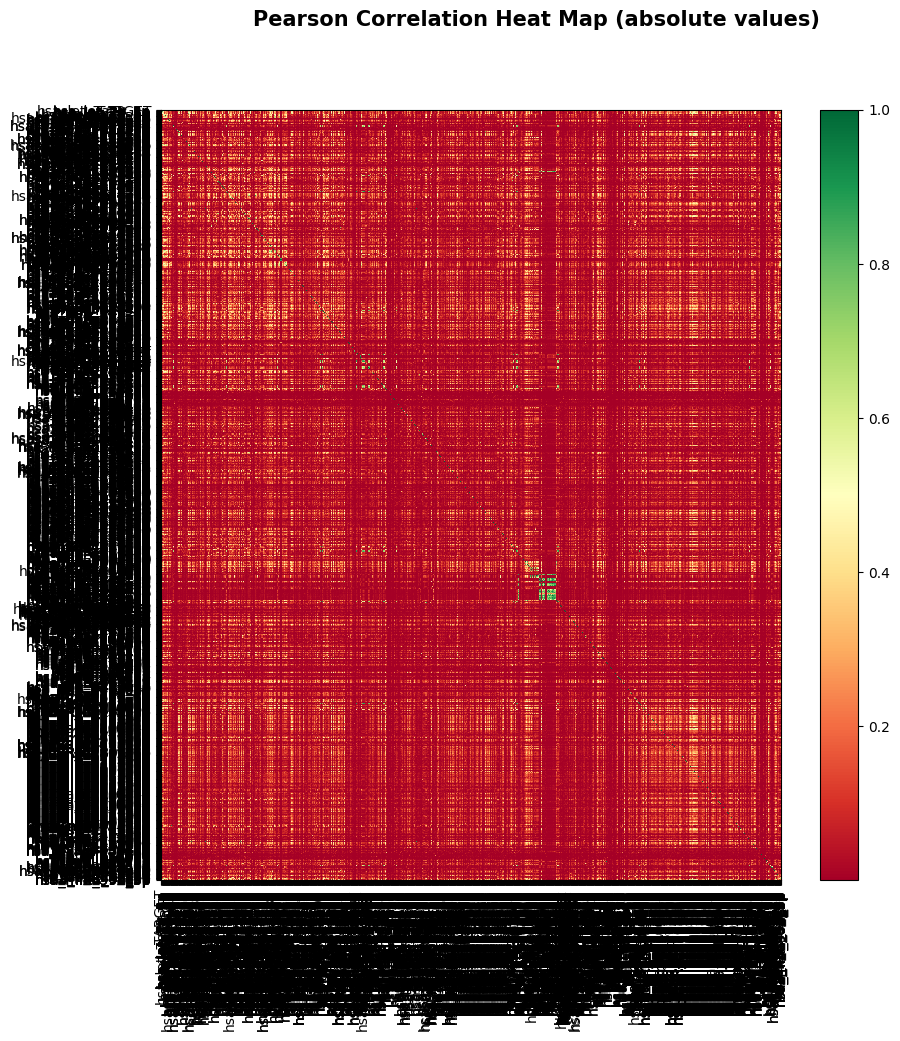

In [6]:
yX, yX_corr, yX_abs_corr = correlation_matrix(y, X, is_plot=True)  

##  1 Univariate feature reduction (remove low correlations with the target)



In [7]:
CORRELATION_MIN = 0.3

# Sort features by their pearson correlation with the target value
s_corr_target = yX_abs_corr['TARGET']
s_corr_target_sort = s_corr_target.sort_values(ascending=False)

# Only use features with a minimum pearson correlation with the target of 0.1
s_low_correlation_ftrs = s_corr_target_sort[s_corr_target_sort <= CORRELATION_MIN]

# Print
print("Removed %d low correlation features:" % len(s_low_correlation_ftrs))
for i,v in enumerate(s_low_correlation_ftrs):
  print(i,v, s_low_correlation_ftrs.index[i])
  
print("---")

s_corr_target_sort = s_corr_target_sort[s_corr_target_sort > CORRELATION_MIN]

print("Remaining %d feature correlations:" % (len(s_corr_target_sort)-1))
for i,v in enumerate(s_corr_target_sort):
  ftr = s_corr_target_sort.index[i]
  if ftr == 'TARGET':
    continue
    
  print(i,v, ftr)

Removed 2223 low correlation features:
0 0.29986390853737543 hsa_miR_1537_5p
1 0.29921522164060793 hsa_miR_491_5p
2 0.2984541407841471 hsa_miR_99a_5p
3 0.29835954677123544 hsa_miR_616_3p
4 0.29741864990862205 hsa_miR_643
5 0.2968815988698065 hsa_miR_193a_3p
6 0.29661846761861355 hsa_miR_301a_3p
7 0.2949263532334505 hsa_miR_181c_5p
8 0.29488428329043176 hsa_miR_30c_5p
9 0.29390359254389786 hsa_miR_2116_5p
10 0.293245315782548 hsa_miR_199b_5p
11 0.29223253613121203 hsa_miR_135b_5p
12 0.29176298041487986 hsa_miR_5699_3p
13 0.29101779492421637 hsa_miR_624_5p
14 0.2908193596707734 hsa_miR_3922_3p
15 0.29060267359001124 hsa_miR_450a_1_3p
16 0.2888370580271069 hsa_miR_145_3p
17 0.28881720134003164 hsa_miR_25_3p
18 0.2880958148248219 hsa_miR_500a_3p
19 0.2871360892854945 hsa_miR_186_3p
20 0.28645081070976347 hsa_miR_1262
21 0.2858156353476225 hsa_miR_497_3p
22 0.28529835401018105 hsa_miR_589_3p
23 0.2852356945334102 hsa_miR_222_3p
24 0.2850791668639202 hsa_miR_1271_5p
25 0.28507735683990343 hs

## 2  Feature reduction based on collinearity (for each highly correlated pair of features, leave only the feature that correlates better with the target value).

In [8]:
CORRELATION_MAX = 0.8

# Remove features that have a low correlation with the target
li_X1_cols = list(set(s_corr_target_sort.index) - set(s_low_correlation_ftrs.index)) 
li_X1_cols.remove('TARGET')

# Build the correlation matrix for the reduced X
X1 = X[li_X1_cols]
yX1, yX_corr1, yX_abs_corr1 = correlation_matrix(y, X1, is_plot=False)  

# Get all the feature pairs
Xcorr1 = yX_abs_corr1.iloc[1:,1:]
s_pairs = Xcorr1.unstack()
print("s_pairs.shape", s_pairs.shape)
s_pairs = s_pairs

# Sort all the pairs by highest correlation values
s_pairs_sorted = s_pairs.sort_values(ascending=False) 
s_pairs_sorted = s_pairs_sorted[(s_pairs_sorted != 1) & (s_pairs_sorted > CORRELATION_MAX)]  # leave only the top matches that are not identical features

# Convert to a list of name tuples e.g. ('mean radius', 'mean perimeter')
li_corr_pairs = s_pairs_sorted.index.tolist()

print("len(li_corr_pairs):", len(li_corr_pairs))
print("li_corr_pairs[:10]", li_corr_pairs[:10])

Function correlation_matrix: X.shape, y.shape, yX.shape: (7950, 180) (7950,) (7950, 181)

s_pairs.shape (32400,)
len(li_corr_pairs): 68
li_corr_pairs[:10] [('hsa_miR_199b_3p', 'hsa_miR_199a_3p'), ('hsa_miR_199a_3p', 'hsa_miR_199b_3p'), ('hsa_miR_500a_5p', 'hsa_miR_500b_5p'), ('hsa_miR_500b_5p', 'hsa_miR_500a_5p'), ('hsa_miR_181a_5p', 'hsa_miR_181b_5p'), ('hsa_miR_181b_5p', 'hsa_miR_181a_5p'), ('hsa_miR_450b_5p', 'hsa_miR_542_3p'), ('hsa_miR_542_3p', 'hsa_miR_450b_5p'), ('hsa_miR_542_3p', 'hsa_miR_542_5p'), ('hsa_miR_542_5p', 'hsa_miR_542_3p')]


## For each of the highest correlated feature pairs, remove the feature that is less correlated with the target


In [9]:
# Build list of features to remove
li_remove_pair_ftrs = []
li_remove_scores = []
for tup in li_corr_pairs:
    s0 = s_corr_target_sort.loc[tup[0]]
    s1 = s_corr_target_sort.loc[tup[1]]
    remove_ftr = tup[1] if s1 < s0 else tup[0]  # get the feature that is less correlated with the target
    if remove_ftr not in li_remove_pair_ftrs:
        li_remove_pair_ftrs.append(remove_ftr)
        di = {'ftr_0':tup[0], 'ftr_1':tup[1], 'score_0':s0, 'score_1':s1, 'FEATURE_TO_REMOVE':remove_ftr}
        li_remove_scores.append(OrderedDict(di))
   
df_remove_scores = pd.DataFrame(li_remove_scores)
print("Removing %d features (see last column):" % len(li_remove_pair_ftrs))
print(df_remove_scores.to_string())
print("---")

# Remove the features that were found in the above procedure
li_X2_cols = list(set(li_X1_cols) - set(li_remove_pair_ftrs)) 
li_X2_cols.sort()

print("Remaining %d features:" % (len(li_X2_cols)))
for i,v in enumerate(s_corr_target_sort):
  ftr = s_corr_target_sort.index[i]

  if ftr in li_X2_cols:
    print(i,v, ftr)

Removing 26 features (see last column):
              ftr_0             ftr_1   score_0   score_1 FEATURE_TO_REMOVE
0   hsa_miR_199b_3p   hsa_miR_199a_3p  0.315009  0.315093   hsa_miR_199b_3p
1   hsa_miR_500a_5p   hsa_miR_500b_5p  0.360039  0.360099   hsa_miR_500a_5p
2   hsa_miR_181a_5p   hsa_miR_181b_5p  0.328296  0.355226   hsa_miR_181a_5p
3   hsa_miR_450b_5p    hsa_miR_542_3p  0.330994  0.340881   hsa_miR_450b_5p
4    hsa_miR_542_3p    hsa_miR_542_5p  0.340881  0.327955    hsa_miR_542_5p
5     hsa_miR_17_5p    hsa_miR_20a_5p  0.337966  0.307880    hsa_miR_20a_5p
6    hsa_miR_27b_3p    hsa_miR_23b_3p  0.386361  0.381510    hsa_miR_23b_3p
7    hsa_miR_542_3p   hsa_miR_450a_5p  0.340881  0.327329   hsa_miR_450a_5p
8    hsa_miR_126_3p    hsa_miR_126_5p  0.322421  0.322868    hsa_miR_126_3p
9   hsa_miR_374b_5p   hsa_miR_374a_5p  0.469221  0.430057   hsa_miR_374a_5p
10  hsa_miR_500b_5p    hsa_miR_502_5p  0.360099  0.355139    hsa_miR_502_5p
11  hsa_miR_130a_3p   hsa_miR_130a_5p  0.363814 

## Plot the correlation matrix for the final dataframe columns

After the pair feature reduction, X2.shape: (7950, 154)
Function correlation_matrix: X.shape, y.shape, yX.shape: (7950, 154) (7950,) (7950, 155)

Remaining features:
TARGET             1.000000
hsa_miR_186_5p     0.540657
hsa_let_7g_5p      0.539170
hsa_miR_98_5p      0.487887
hsa_miR_374b_5p    0.469221
                     ...   
hsa_miR_5586_5p    0.303874
hsa_miR_511_5p     0.302171
hsa_miR_1277_3p    0.301390
hsa_miR_1287_5p    0.300901
hsa_miR_27b_5p     0.300433
Name: TARGET, Length: 155, dtype: float64
---
After the pair feature reduction, X2.shape: (7950, 154)
Function correlation_matrix: X.shape, y.shape, yX.shape: (7950, 154) (7950,) (7950, 155)



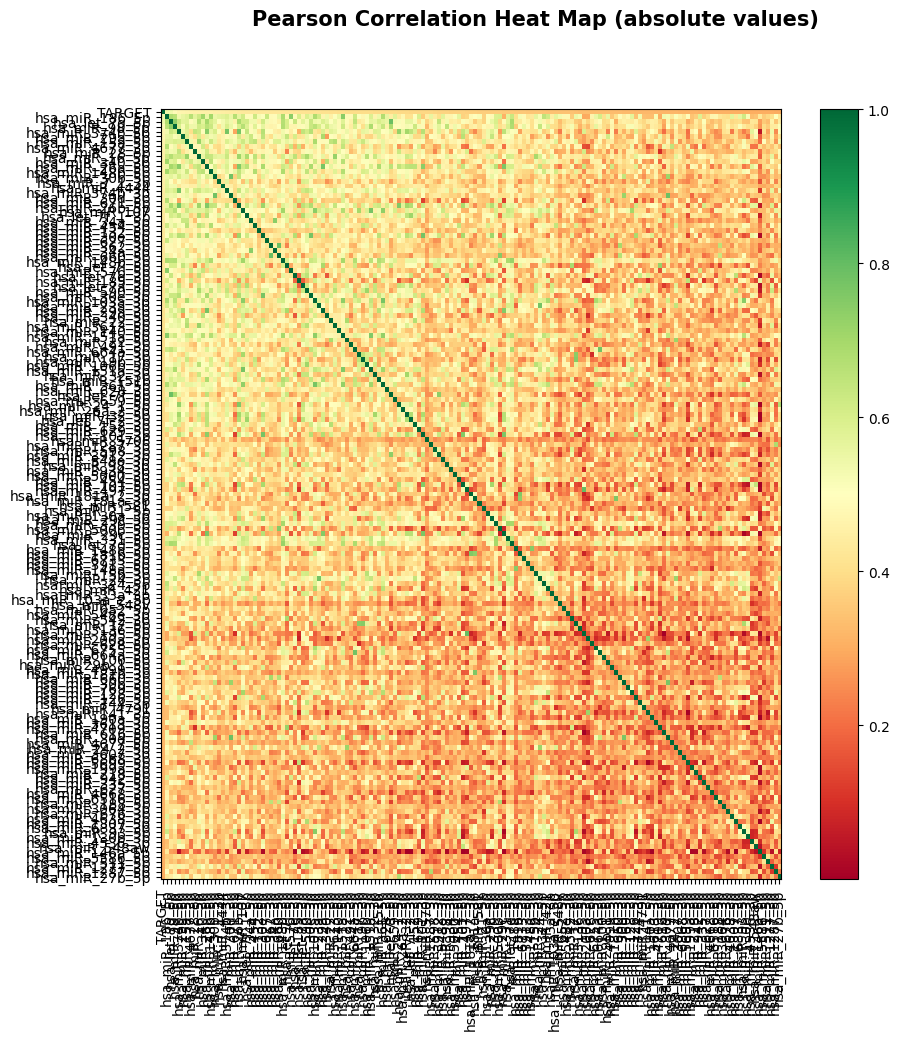

In [10]:
# Calculate correlation matrix on the subset of features
X2 = X1[li_X2_cols]
print("After the pair feature reduction, X2.shape:", X2.shape)
yX2, yX_corr2, yX_abs_corr2 = correlation_matrix(y, X2)

# Recalculate the correlation matrix in order to plot the TARGET values in order of correlation
s_X3_cols = yX_abs_corr2['TARGET'].sort_values(ascending=False)
li_X3_cols = s_X3_cols.index.tolist()
print("Remaining features:")
print(s_X3_cols)
print("---")
li_X3_cols.remove('TARGET')

X3 = X2[li_X3_cols]
print("After the pair feature reduction, X2.shape:", X3.shape)
yX3, yX_corr3, yX_abs_corr3 = correlation_matrix(y, X3, is_plot=True)
X=X3

## Split and scale the dataset

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_l,
    random_state=42,
    test_size=0.30
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
scaler = StandardScaler()
print('\nData preprocessing with {scaler}\n'.format(scaler=scaler))
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

(5565, 154) (5565,)
(2385, 154) (2385,)

Data preprocessing with StandardScaler()



## Define the Deep MLP model

In [12]:
mlp = MLPClassifier(
    hidden_layer_sizes = (256,256,256,256),
    max_iter=5000,
    alpha=0.01,
    activation='relu',
    solver='adam',
    # random_state=42
)


## Train the model

In [13]:
mlp.fit(X_train_scaler, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=(256, 256, 256, 256),
              max_iter=5000)

## Evaluate the model

In [14]:
mlp_predict = mlp.predict(X_test_scaler)
mlp_predict_proba = mlp.predict_proba(X_test_scaler)[:, 1]
print('MLP Accuracy: {:.2f}%'.format(accuracy_score(y_test, mlp_predict) * 100))

MLP Accuracy: 93.54%


## Save the trained model

In [15]:
# Save the trained model
ofile = bz2.BZ2File("mlp_model.pk.bz2",'wb')
pickle.dump(mlp,ofile)
# close the file
ofile.close()